# Dopełnienie Schur'a z użyciem eliminacji Gaussa

**Maciej Skoczeń**, **Kacper Kafara**

grupa wtorek (A) 17:50

## Środowisko obliczeniowe

**OSOBA WYKONUJĄCA OSTATECZNE OBLICZENIA POWINNA WPISAĆ TUTAJ SPECYFIKACJĘ SWOJEGO SPRZĘTU**

## Importy & typy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import subprocess
import matplotlib.pyplot as plt

from timeit import default_timer
from pprint import pprint
from math import sqrt

Array = np.ndarray

## Funkcje pomocnicze

In [2]:
class Timer(object):
    def __init__(self):
        self._start_time = None
        self._stop_time = None

    def start(self):
        self._start_time = default_timer()

    def stop(self):
        self._stop_time = default_timer()

    @property
    def elapsed(self, val = None):
        if self._stop_time is None or self._start_time is None:
            return None
        elapsed = self._stop_time - self._start_time
        return elapsed

# mock impl
def is_int(value) -> bool:
    as_int = int(value)
    return value == as_int

###  Wczytywanie macierzy

wygenerowanej za pomocą dostarczonego skryptu `mass_matrix`

In [3]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+),\s*(\d+)\)\s*->\s*(\d+\.\d+)\s*", elem)
        if m is not None:
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [4]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [5]:
data_dir = "../../output"

def resolve_path(matrix_type, width, height = None, generate = False):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    else: 
        if not generate:
            raise FileNotFoundError(f"Matrix file {path} not found")
            
        # do generowania macierzy potrzebny jest direnv, ustawiona zmienna 
        # środowiskowa: 
        # SCRIPT_DIR=<path-to-scripts-dir>
        # albo na sztywno ustawiona ścieżka do skryptu (ale wtedy trzeba zmodyfikować)
        # funkcję generate_matrix
        
        if width != height:
            raise ValueError("Can only generate square matrix")
            
        generate_matrix(matrix_type, width)
        
        if os.path.isfile(path): return path
        else:
            print(path)
            raise RuntimeError("Failed to generate matrix")


resolve_matrix = lambda matrix_type, n, m, q = 1: input_matrix(
    load_octave_matrix(resolve_path(matrix_type, n, m)), n, m, q
)

def resolve_matrix(matrix_type, n, m, q = 1, generate = False):
    return input_matrix(
        load_octave_matrix(resolve_path(matrix_type, n, m, generate = generate)), n, m, q
    )

def generate_matrix(matrix_type, rank):
    if matrix_type not in {'iga', 'fem'}:
        raise ValueError(f"Invalid matrix type: {matrix_type}")
        
    if rank < 16 or not is_int(sqrt(rank)):
        raise ValueError(f"Invalid matrix rank: {rank}. Must be >= 16 and sqrt(rank) must be of type integer.")
        
    rank_root = int(sqrt(rank))
    
    if matrix_type == 'fem':
        for p in range(2, 5):
            double_nxx = rank_root - p + 1
            if double_nxx % 2 == 0 and double_nxx // 2 >= 2:
                nxx = double_nxx // 2
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    else:
        for p in range(2, 5):
            nxx = rank_root - p
            if nxx >= 2:
                pxx = p
                break
        else:
            raise RuntimeError(f"Failed to determine nxx, pxx for rank: {rank}")
    
    cwd = os.getcwd()
    scripts_dir = os.getenv('SCRIPTS_DIR')
    os.chdir(scripts_dir)
    !./generate-matrix.sh cpp {matrix_type} {nxx} {pxx} 0
    os.chdir(cwd)

## Eliminacja Gaussa

In [6]:
def transform_matrix_gaussian_elim(
    A: Array,
    rows_to_transform: int,
    in_place: bool = False,
    timer: Timer = None
) -> Array:
    
    if not in_place: A = A.copy()
    
    if timer is not None:
        timer.start()

    n, _ = A.shape
    for i in range(0, min(n - 2, rows_to_transform)):
        for j in range(i + 1, n):
            factor = A[j, i] / A[i, i]
            A[j, i] = 0
            for k in range(i + 1, n):
                A[j, k] -= factor * A[i, k]
                
    if timer is not None: timer.stop()
    if not in_place: return A

## Dopełnienie Schur'a

In [7]:
def schur_complement(A: Array, complement_degree: int, timer: Timer = None) -> Array:
    transformed = transform_matrix_gaussian_elim(A,
                                                 A.shape[0] - complement_degree,
                                                 in_place = False,
                                                 timer = timer)
    return transformed[A.shape[0] - complement_degree :, A.shape[1] - complement_degree :]

In [8]:
!pwd

/home/kkafara/studies/cs/5_term/algmac/lab/gaussian-elimination/notebook


In [9]:
NXX_RANGE = range(2, 10)
nxxs = [i for i in NXX_RANGE]
pxx = 2
rxx = 0
ranks = {}
ranks['iga'] = [(nxx + pxx) ** 2 for nxx in nxxs]
ranks['fem'] = [(2 * nxx + pxx - 1) ** 2 for nxx in nxxs]

matrixtypes = 'iga', 'fem'

main_timer = Timer()
exec_times = {
    'iga': {},
    'fem': {}
}
exec_ranks = {
    'iga': {},
    'fem': {},
}
    
padding = lambda n: n * ' '

for matrix_t in matrixtypes:
    matrices = ((resolve_matrix(matrix_t, rank, rank, generate=True), rank) for rank in ranks[matrix_t])
    print('Computations for matrix type: ', matrix_t)
    for M, rank in matrices:
        print(padding(2) + 'Computations for rank', rank)
        
        exec_times[matrix_t][rank] = []
        exec_ranks[matrix_t][rank] = []
        rank_cp = rank
        
        while rank_cp >= 2:
            rank_cp //= 2
            print(padding(4) + 'Current rank:', rank_cp, end = '  ')
            
            schur_complement(M, rank_cp, timer = main_timer)
            
            exec_times[matrix_t][rank].append(main_timer.elapsed)
            exec_ranks[matrix_t][rank].append(rank_cp)
            
            print(f'{main_timer.elapsed:.5f}s')

        
# narysować wykresy

Computations for matrix type:  iga
  Computations for rank 16
    Current rank: 8  0.00170s
    Current rank: 4  0.00200s
    Current rank: 2  0.00080s
    Current rank: 1  0.00071s
  Computations for rank 25
    Current rank: 12  0.00246s
    Current rank: 6  0.00268s
    Current rank: 3  0.00251s
    Current rank: 1  0.00264s
  Computations for rank 36
    Current rank: 18  0.00554s
    Current rank: 9  0.00595s
    Current rank: 4  0.00498s
    Current rank: 2  0.00486s
    Current rank: 1  0.00476s
  Computations for rank 49
    Current rank: 24  0.01073s
    Current rank: 12  0.01201s
    Current rank: 6  0.01223s
    Current rank: 3  0.01481s
    Current rank: 1  0.01225s
  Computations for rank 64
    Current rank: 32  0.02374s
    Current rank: 16  0.02669s
    Current rank: 8  0.02686s
    Current rank: 4  0.02999s
    Current rank: 2  0.02748s
    Current rank: 1  0.02728s
  Computations for rank 81
    Current rank: 40  0.04894s
    Current rank: 20  0.05379s
    Current ran

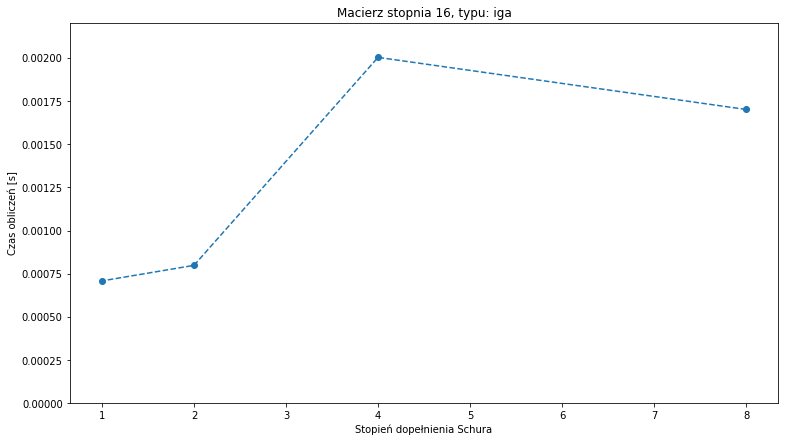

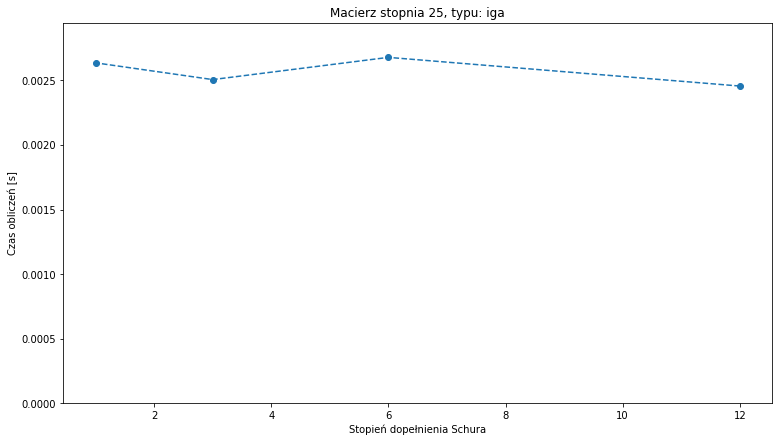

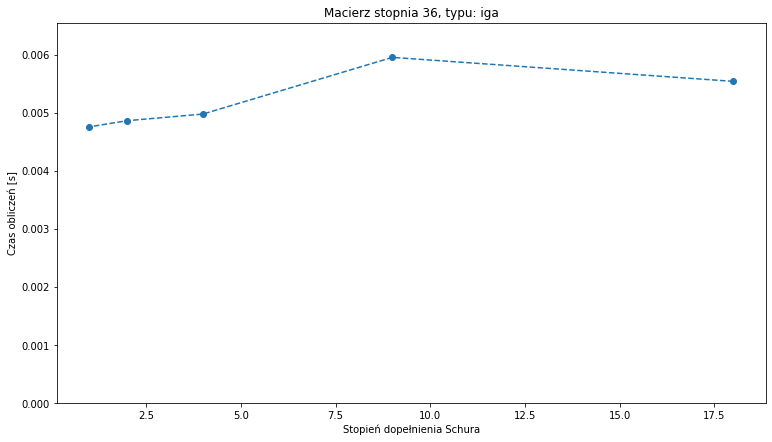

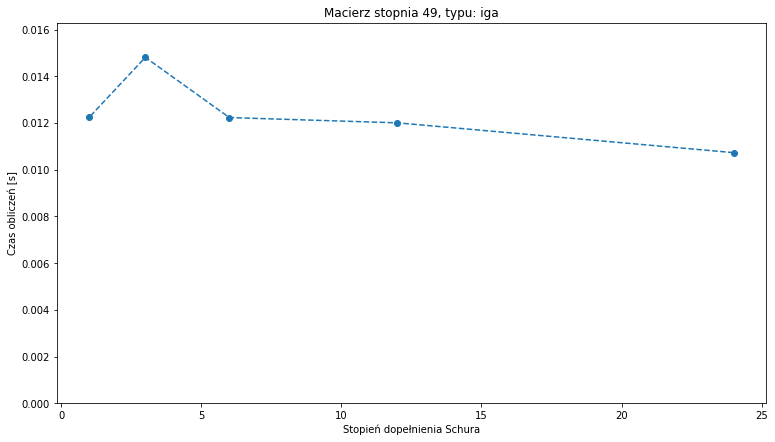

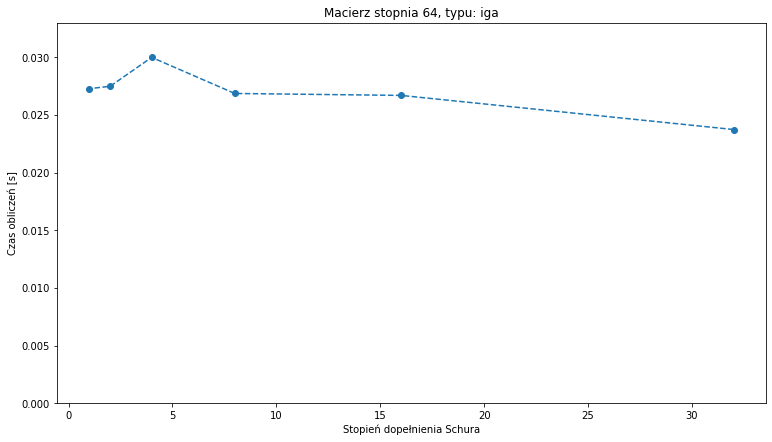

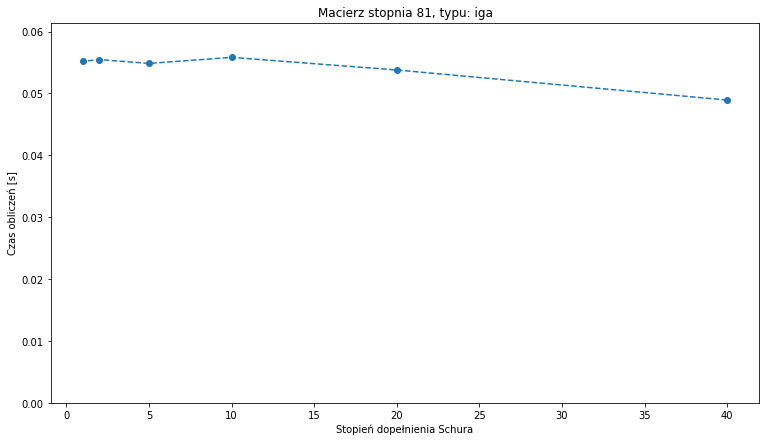

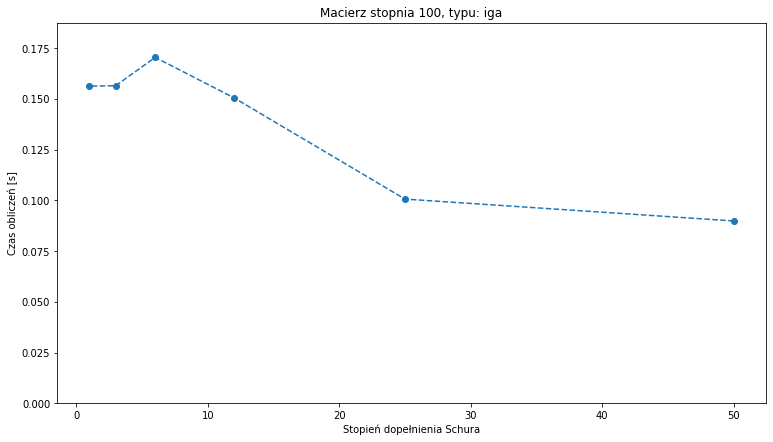

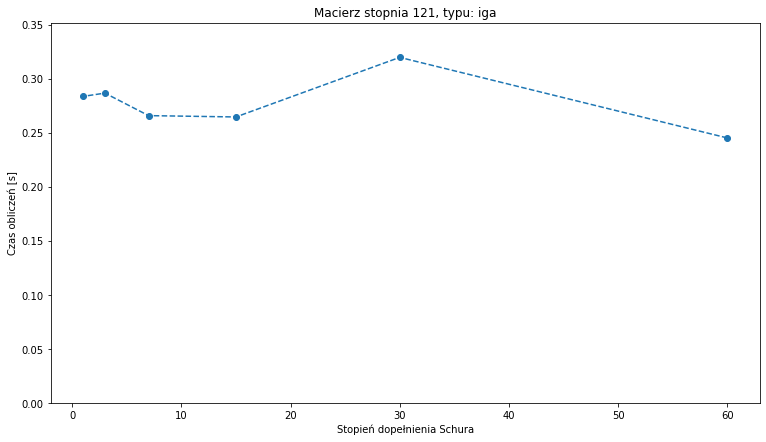

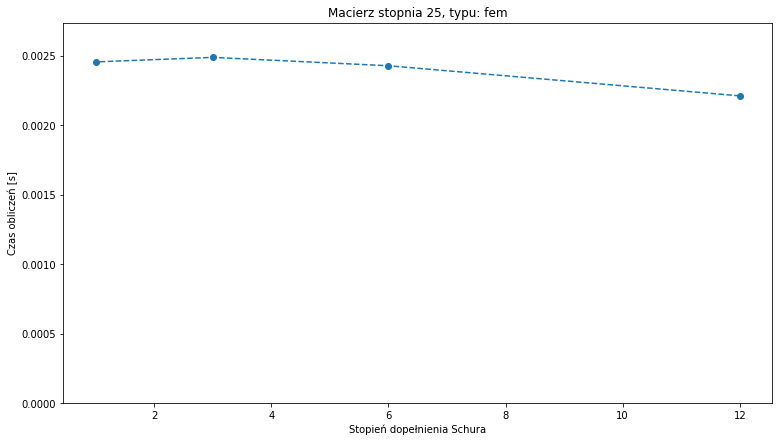

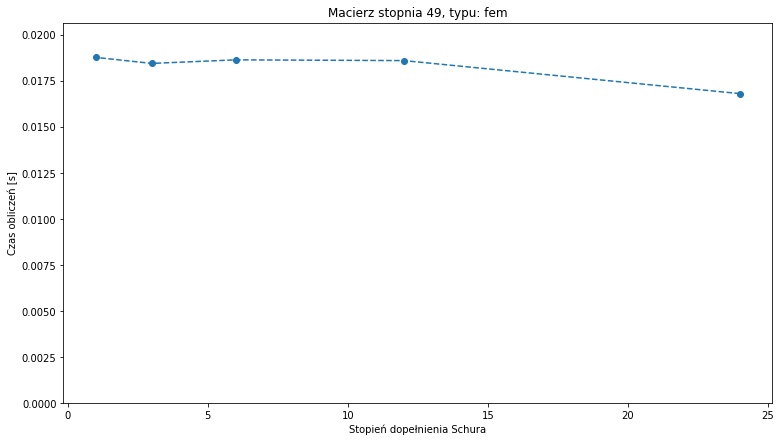

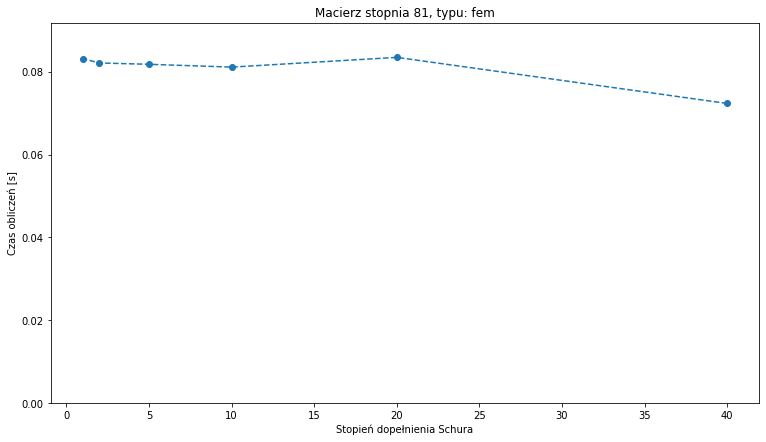

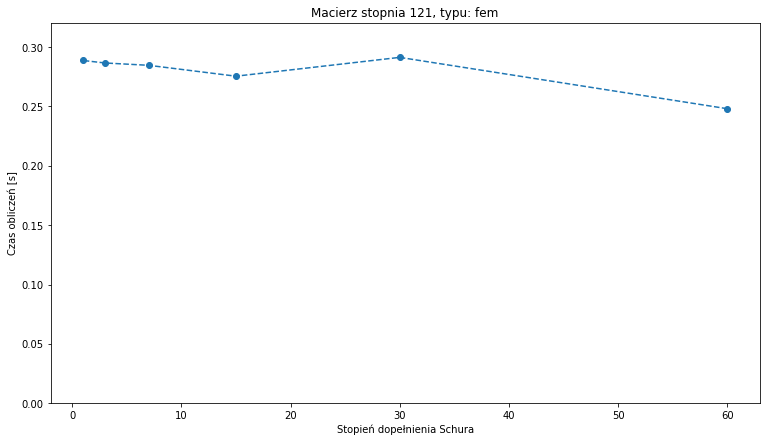

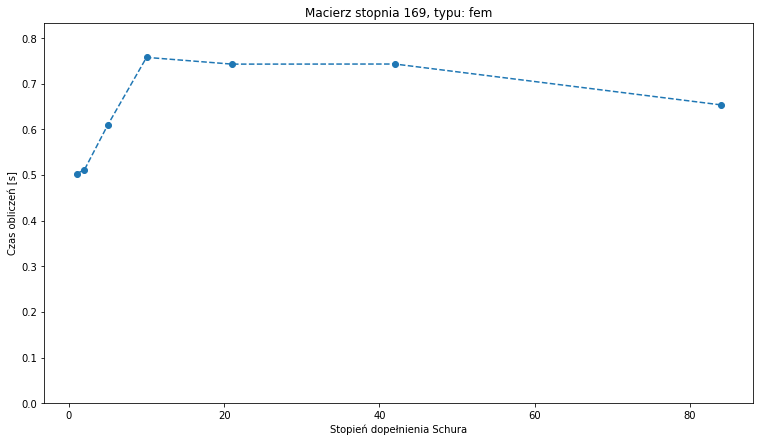

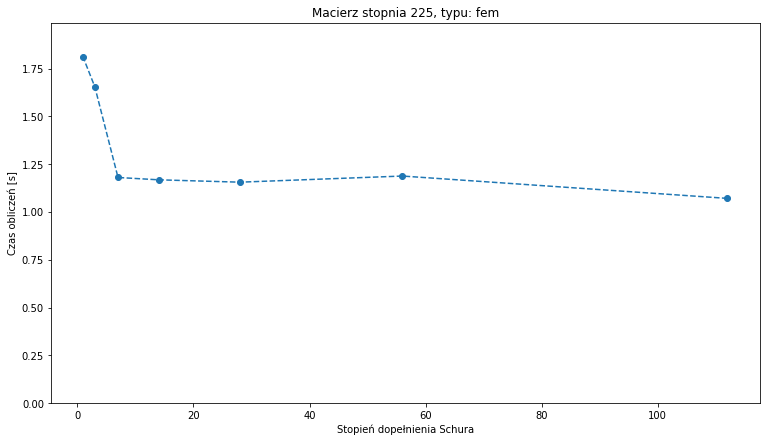

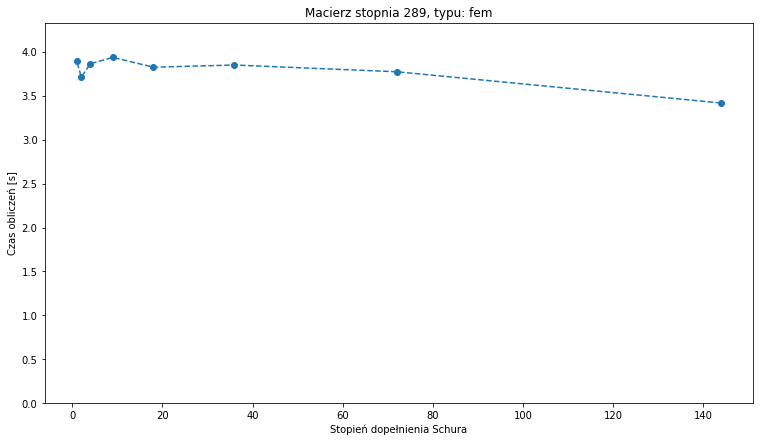

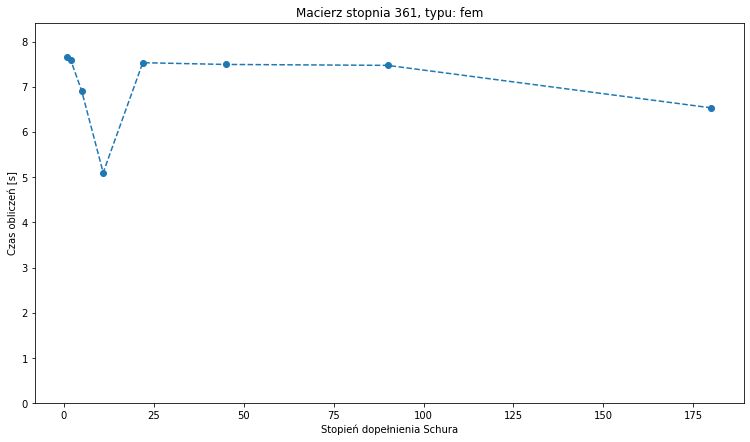

In [19]:
%matplotlib inline

for matrix_t in matrixtypes:
    for rank in ranks[matrix_t]:
        _, ax = plt.subplots(figsize=(12.7, 7))
        
        max_y = max(exec_times[matrix_t][rank])
        max_y += 0.1 * max_y
        plt.ylim(0, max_y)
        
        ax.scatter(
            exec_ranks[matrix_t][rank],
            exec_times[matrix_t][rank],
            label=f'{matrix_t}'
        )
        
        ax.plot(
            exec_ranks[matrix_t][rank],
            exec_times[matrix_t][rank],
            linestyle='--'
        )
        
        ax.set(
            xlabel='Stopień dopełnienia Schura',
            ylabel='Czas obliczeń [s]',
            title=f'Macierz stopnia {rank}, typu: {matrix_t}'
        )